In [11]:
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pylab as pl
import sciris as sc
import covasim as cv
import scipy as sp
import optuna as op
import pandas as pd
from datetime import datetime, date
import json


import random
import time

from functions_total import *  # all auxiliary functions

import warnings
warnings.filterwarnings("ignore")

import calibration_total as st
from calibration_total import model


# Novosibirsk dataset

In [2]:
po = json.load(
    open(os.path.expanduser('./pop_covasim.json')))
popdict = {}
for i in po:
    popdict[int(i)] = po[i]
    for j in ['H', 'S', 'W', 'C']:
        popdict[int(i)]['contacts'][j] = set(po[i]['contacts'][j])

In [3]:
# basic parameters

location='Chelyabinsk'
pop_location=40797
cal_keys=['new_diagnoses', 'cum_diagnoses', 'new_deaths'] # ключи для калибровки
cal_values=[2, 1, 3] # веса для параметров
pop_inf=[98,1,150] # количество первоначально зараженных: лучшее, мин, макс

data_csv="Chelyabinsk_dataset.csv"

# load Novosibirsk data
df1=pd.read_csv(data_csv,index_col=0,parse_dates=True)
# df1.drop(columns=['icu'], inplace=True)

# state_url = 'http://covid19-modeling.ru/data/novosibirsk-region-data-small.csv'
# data = pd.read_csv(state_url, index_col="date", parse_dates=True, na_values=['nan'])
# state_data = data.sort_values(by=['date'])
# data.to_csv(data_csv)
# df1=pd.read_csv(data_csv,index_col=0,parse_dates=True)

# fill unknown tests
#df1.new_diagnoses=past_extr(df=df1,series=df1.new_diagnoses,n=df1['new_diagnoses'].isna().sum())
df1.new_tests=past_extr(df=df1,series=df1.new_tests,n=df1['new_tests'].isna().sum())
df1=smooth_pd(df1)
df1['date']=df1.index

# define start day and last day, bounds_of_periods for calibration
start_day=cv.date(df1.index[0].to_pydatetime().date())
last_day=cv.date(df1.index[-1].to_pydatetime().date())
bounds_of_periods=bounds_of_per(start_day,last_day)
bounds_of_periods.append(cv.date(last_day, as_date=False))
                         
# parameters for plotting
figsize=(18,5)
fontsize=18
fontsize_legend=15
linewidth=2
ticks=50
rotation=0
dateformat='%Y.%m.%d'

# Import calibrated parameters

In [4]:
df1.head(44)

,new_diagnoses,cum_diagnoses,new_deaths,cum_deaths,cum_tests,new_tests,n_critical,ventilation,date
date,,,,,,,,,
2020-03-03,14,31,0,0,1958,695,0,NaN,2020-03-03
2020-03-04,16,39,0,0,2160,703,0,NaN,2020-03-04
2020-03-05,21,56,0,0,2542,716,0,NaN,2020-03-05
2020-03-06,27,81,0,0,3067,730,0,NaN,2020-03-06
2020-03-07,36,116,0,0,3693,741,0,NaN,2020-03-07
2020-03-08,45,162,0,0,4382,748,0,NaN,2020-03-08
2020-03-09,57,219,0,0,5106,752,0,NaN,2020-03-09
2020-03-10,72,291,0,0,5849,754,0,NaN,2020-03-10
2020-03-11,89,380,0,0,6604,758,0,NaN,2020-03-11


In [5]:
# import calibrated parameters for Novosibirsk
calibrated_params=open('p_autocal_total.json','r')
p=json.load(calibrated_params)


# define beta_changes and beta_days from calibrated parameters in list 'p'
b_days=[]
b_changes=[]
for i in range(len(p)):
    b_days.append(p[i][f'beta_day_{i+1}'])
    b_changes.append(p[i][f'beta_change_{i+1}'])
b_days=list(map(int, b_days))


# dates of beta_change
b_change_model=cv.date(b_days,start_date=start_day, as_date=False)

#  Full autcalibration

p before calibration []
Modeling  2020-03-03  -  2020-04-02
Running initial uncalibrated simulation...


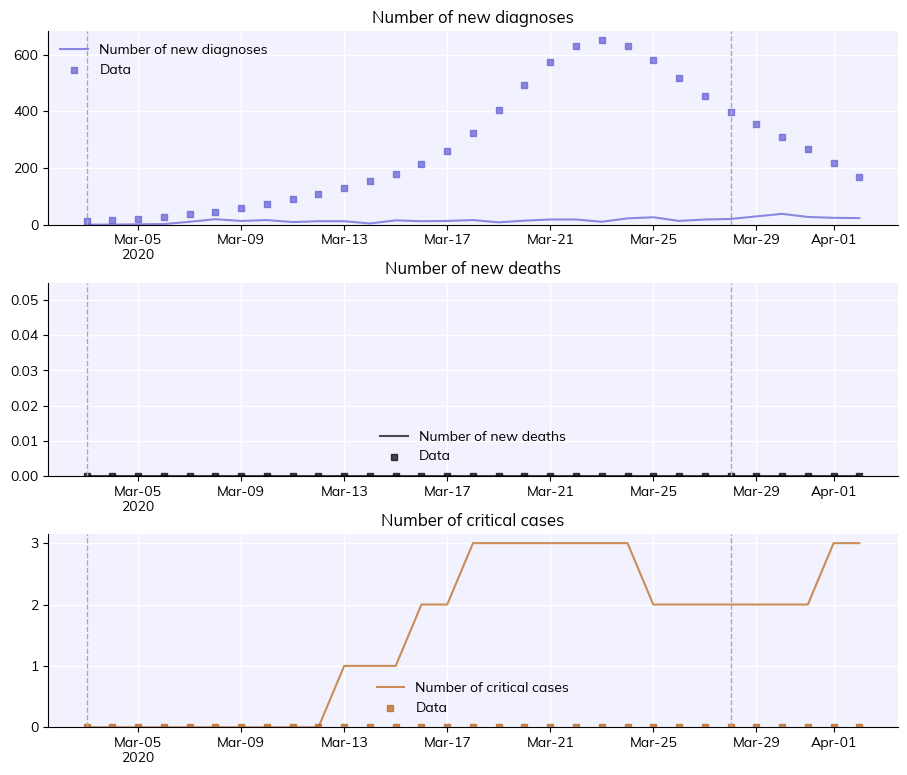

<Figure size 640x480 with 0 Axes>

Starting calibration for Novosibirsk


[I 2024-04-18 19:50:46,017] A new study created in RDB with name: covasim
[I 2024-04-18 19:50:50,870] Trial 0 finished with value: 36.5868272886809 and parameters: {'pop_infected': 107.69862994070722, 'beta': 0.011551213324346808, 'beta_day': 4.312881103194027, 'beta_change': 0.3066511802126155, 'symp_test': 197.87850841988873}. Best is trial 0 with value: 36.5868272886809.
[I 2024-04-18 19:50:55,848] Trial 1 finished with value: 35.71498062298918 and parameters: {'pop_infected': 70.54616403641951, 'beta': 0.017315768012579044, 'beta_day': 18.204933607336475, 'beta_change': 0.8346823314462248, 'symp_test': 40.94485409580322}. Best is trial 1 with value: 35.71498062298918.
[I 2024-04-18 19:51:00,903] Trial 2 finished with value: 37.189134249780636 and parameters: {'pop_infected': 7.416127868799965, 'beta': 0.01116436201738348, 'beta_day': 25.356022039481026, 'beta_change': 0.5137277077884078, 'symp_test': 122.66634201668441}. Best is trial 1 with value: 35.71498062298918.
[I 2024-04-18 

Mismatch: 31.934555791167007
Elapsed time: 518 s
Plotting result...


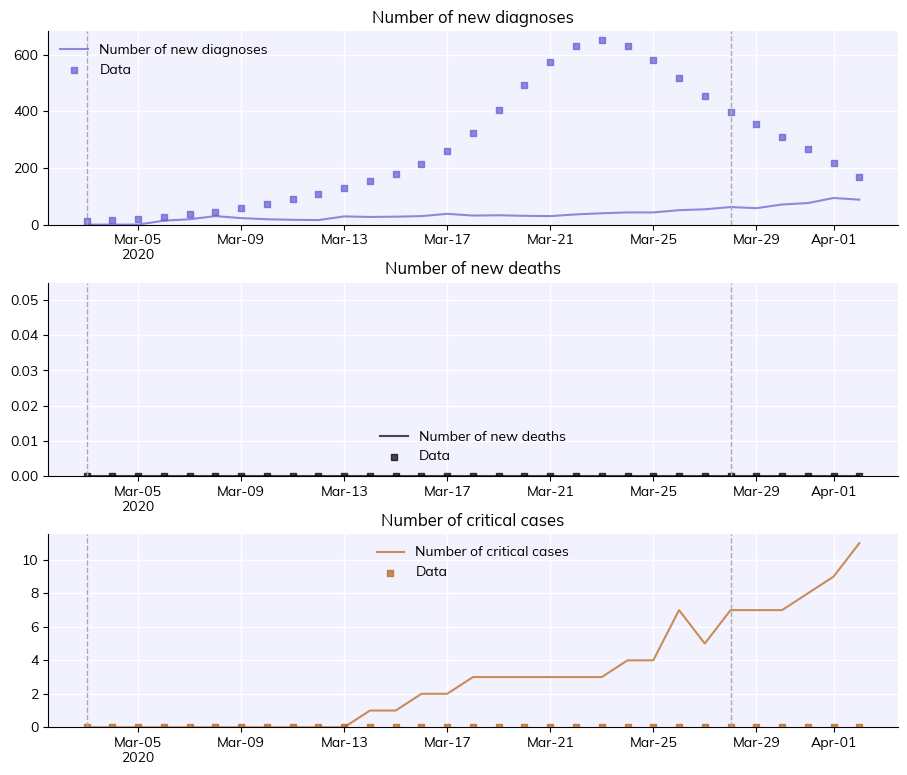

p after calibration [{'pop_infected': 149.9365294423656, 'beta': 0.024982093664955626, 'symp_test': 105.47495210128643, 'beta_change_1': 0.9584786730868826, 'beta_day_1': 25.56103008252088}]
p before calibration [{'pop_infected': 149.9365294423656, 'beta': 0.024982093664955626, 'symp_test': 105.47495210128643, 'beta_change_1': 0.9584786730868826, 'beta_day_1': 25.56103008252088}]
Modeling  2020-03-03  -  2020-04-15
Running initial uncalibrated simulation...


<Figure size 640x480 with 0 Axes>

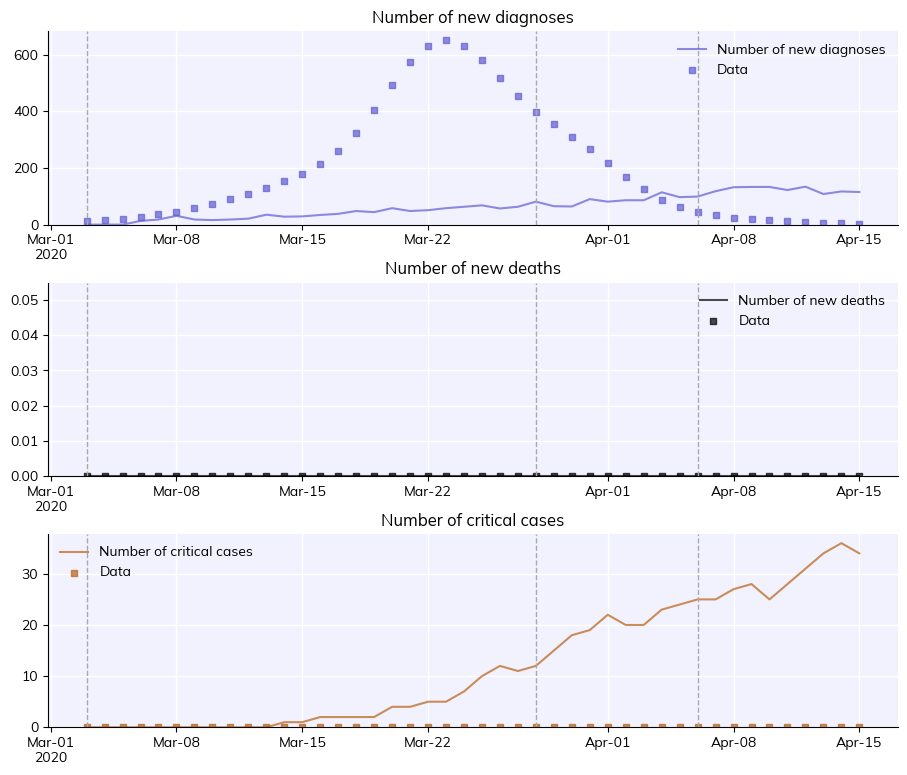

<Figure size 640x480 with 0 Axes>

Starting calibration for Novosibirsk


[I 2024-04-18 19:59:38,536] A new study created in RDB with name: covasim
[I 2024-04-18 19:59:43,806] Trial 0 finished with value: 44.80010413773951 and parameters: {'beta_day': 32.455242411491604, 'beta_change': 0.5357799809989023}. Best is trial 0 with value: 44.80010413773951.
[I 2024-04-18 19:59:49,116] Trial 1 finished with value: 46.4435344348792 and parameters: {'beta_day': 36.02705598420509, 'beta_change': 1.0158273166820087}. Best is trial 0 with value: 44.80010413773951.
[I 2024-04-18 19:59:54,140] Trial 2 finished with value: 46.518696889752846 and parameters: {'beta_day': 41.04515734677284, 'beta_change': 0.7093623533117723}. Best is trial 0 with value: 44.80010413773951.
[I 2024-04-18 19:59:59,465] Trial 3 finished with value: 46.000414121077476 and parameters: {'beta_day': 41.45937435595947, 'beta_change': 0.6919062389346242}. Best is trial 0 with value: 44.80010413773951.
[I 2024-04-18 20:00:04,733] Trial 4 finished with value: 46.31274958344905 and parameters: {'beta_da

Mismatch: 42.55135517911691
Elapsed time: 533 s
Plotting result...


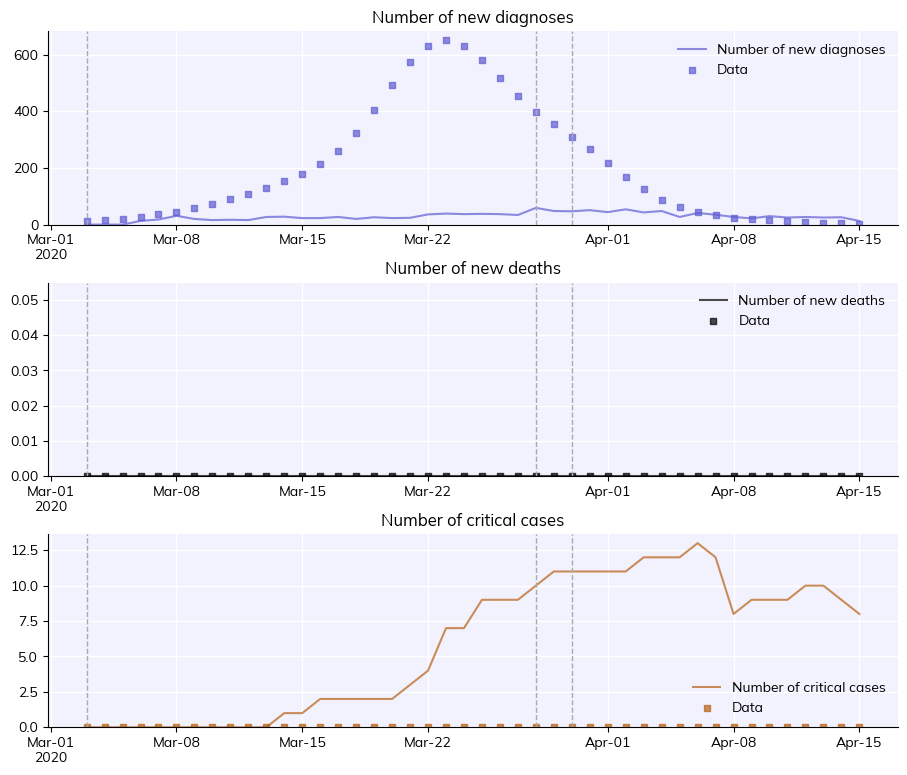

p after calibration [{'pop_infected': 149.9365294423656, 'beta': 0.024982093664955626, 'symp_test': 105.47495210128643, 'beta_change_1': 0.9584786730868826, 'beta_day_1': 25.56103008252088}, {'beta_change_2': 0.3065158009987279, 'beta_day_2': 27.380053882319892}]


<Figure size 640x480 with 0 Axes>

In [6]:
# do autocalibration

# create an empty list for calibrated parameters
p=[]

for i in range(len(bounds_of_periods)):
    print('p before calibration', p)
    sim,p=calibration_process(param=p, datafile=df1, location=location, pop_location=pop_location, start_day=start_day,
                              end_day=bounds_of_periods[i], cal_keys=cal_keys, cal_values=cal_values, pop_inf=pop_inf,
                              #n_runs=n_runs, n_workers=n_workers,
                              popdict=popdict)
    print('p after calibration', p)

with open('p_autocal_total.json', 'w') as jsonfile:
    json.dump(p, jsonfile)

# Difining if we need to run new calibration

In [14]:
previous_cal_day='2021-01-17'
previous_cal_day, day_today, run_calibration=if_new_calib(previous_cal_day=previous_cal_day, timedelt=40)

if run_calibration:
    sim,p = calibration_process(param=p, datafile=df1, location=location, pop_location=pop_location, start_day=start_day,
                              end_day=day_today, cal_keys=cal_keys, cal_values=cal_values, pop_inf=pop_inf,
                              school_days=school_days, school_changes=school_changes)
    sim=run_model(p=p, end_day=day_today,location=location, pop_location=pop_location, start_day=start_day, school_days=school_days, school_changes=school_changes, 
                 b_days=b_days, b_changes=b_changes, data=df1,run=True)
else: 
    sim=run_model(p=p, end_day=day_today,location=location, pop_location=pop_location, start_day=start_day, school_days=school_days, school_changes=school_changes, 
                 b_days=b_days, b_changes=b_changes, data=df1,run=True)
    
#sim.plot(to_plot=['new_diagnoses','new_infections'],show_args={'interventions':False})

# Confedential interval

Initializing sim with 100000 people for 43 days
Initializing sim with 100000 people for 43 daysLoading location-specific data for "Chelyabinsk"

Loading location-specific data for "Chelyabinsk"
Initializing sim with 100000 people for 43 days
Loading location-specific data for "Chelyabinsk"
Initializing sim with 100000 people for 43 days
Initializing sim with 100000 people for 43 daysLoading location-specific data for "Chelyabinsk"

Loading location-specific data for "Chelyabinsk"
Initializing sim with 100000 people for 43 days
Loading location-specific data for "Chelyabinsk"
Initializing sim with 100000 people for 43 days
Loading location-specific data for "Chelyabinsk"Initializing sim with 100000 people for 43 days

Loading location-specific data for "Chelyabinsk"
Initializing sim with 100000 people for 43 days
Loading location-specific data for "Chelyabinsk"Initializing sim with 100000 people for 43 days

Loading location-specific data for "Chelyabinsk"
msim successfully run


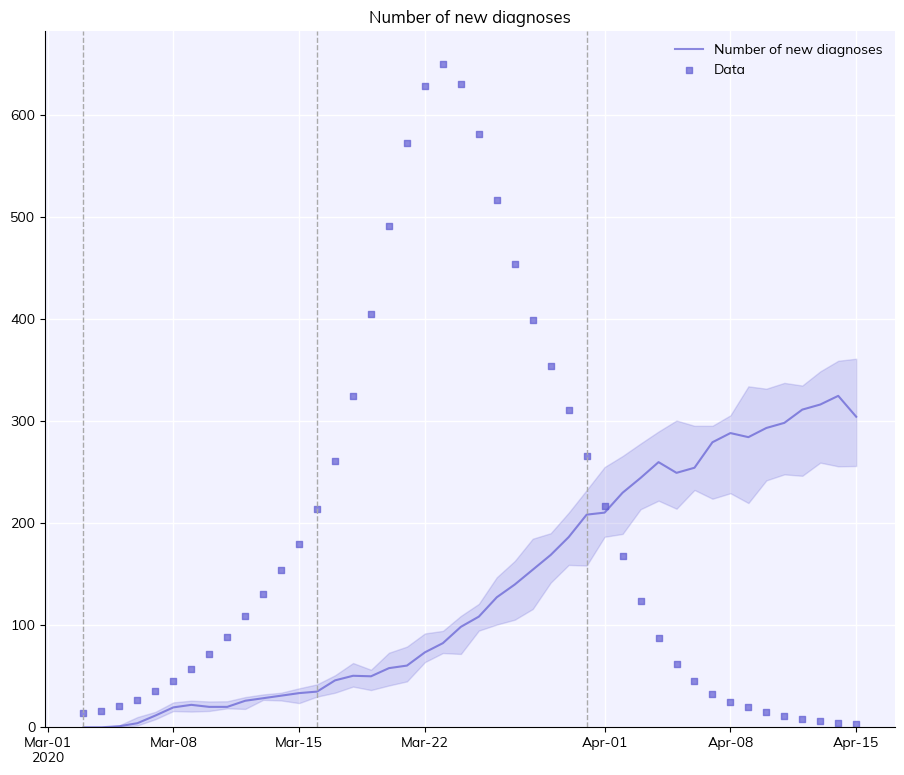

In [8]:
sim=run_model(p=p, location=location, pop_location=pop_location, start_day=start_day, end_day=last_day, 
              b_days=b_days, b_changes=b_changes, data=df1, run=False, popdict=popdict)
namesim=''
# run multiple sims to calculate confidential interval
run_msim_conf(sim=sim, to_plot=['new_diagnoses'], save=True, namemsim=namesim)

In [9]:
# detailed plot of confidential interval
msi=cv.load('msim_p_autocal_04_02.sim')
dday=80
test_data=None


msi.plot(to_plot=['new_diagnoses'],fig_args={'figsize': figsize},test_data=test_data)
msi.plot(to_plot=['new_diagnoses'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['new_deaths'],fig_args={'figsize': figsize},test_data=test_data)
msi.plot(to_plot=['new_deaths'],fig_args={'figsize': figsize},dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['new_recoveries'],fig_args={'figsize': figsize}, test_data=test_data)
msi.plot(to_plot=['new_recoveries'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['n_critical'],fig_args={'figsize': figsize}, test_data=test_data)
msi.plot(to_plot=['n_critical'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)

FileNotFoundError: [Errno 2] No such file or directory: '/home/timofei/Desktop/autocalibration-covasim-pub-mod/msim_p_autocal_04_02.sim'

# Prognose

In [10]:
n_future=30
forecast=future_extr(filename=data_csv, df1=df1, end_day=last_day, n_future=n_future)
forecast=pd.Series(smooth(forecast),index=[df1.index[-1] + timedelta(days=i) for i in range(1, n_future+2)])
forecast.name ='new_tests'
forecast = forecast.to_frame()

forecast_data=pd.concat([df1,forecast])
forecast_data['date']=forecast_data.index
#print(forecast_data[-n_future-5:])


# define parameters for prognose
n_runs=10
save=True
namesim=''
plot=False
to_plot=['new_diagnoses','new_deaths','new_recoveries', 'new_severe','new_critical'] 


# do prognose
prognose(forecast_data=forecast_data, start_day=start_day, location=location, pop_location=pop_location, p=p,
         to_plot=to_plot, b_days=b_days, b_changes=b_changes, school_days=school_days, 
         school_changes=school_changes, n_runs=n_runs, save=save, namemsim=namesim, plot=plot)

TypeError: future_extr() got an unexpected keyword argument 'df1'

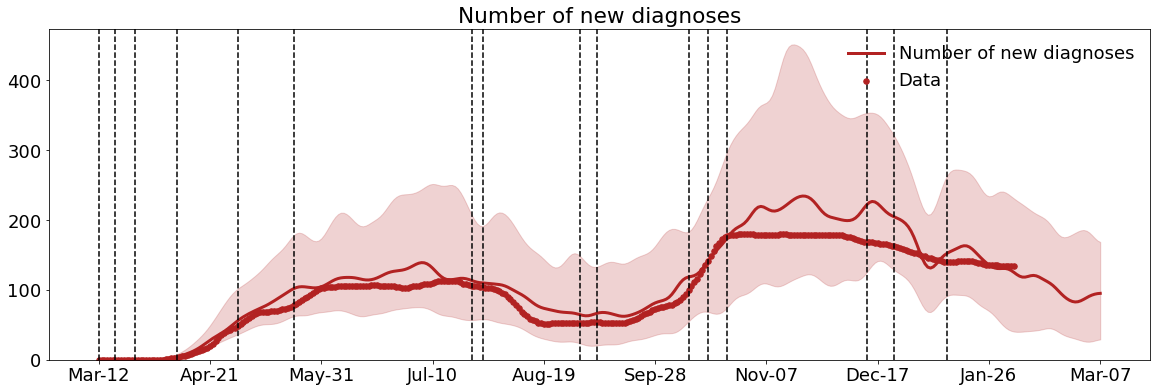

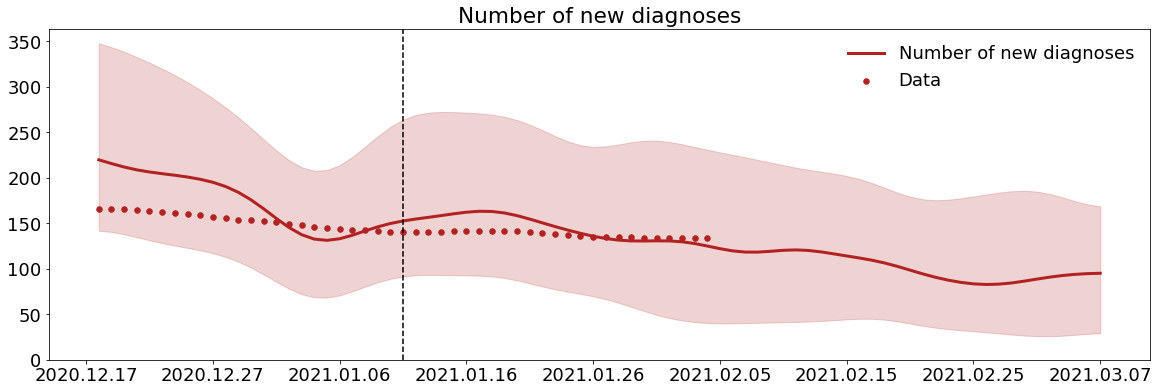

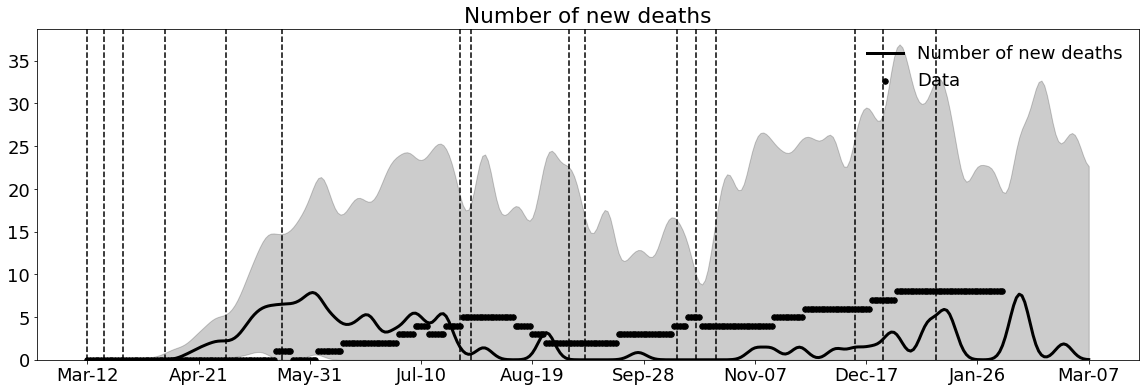

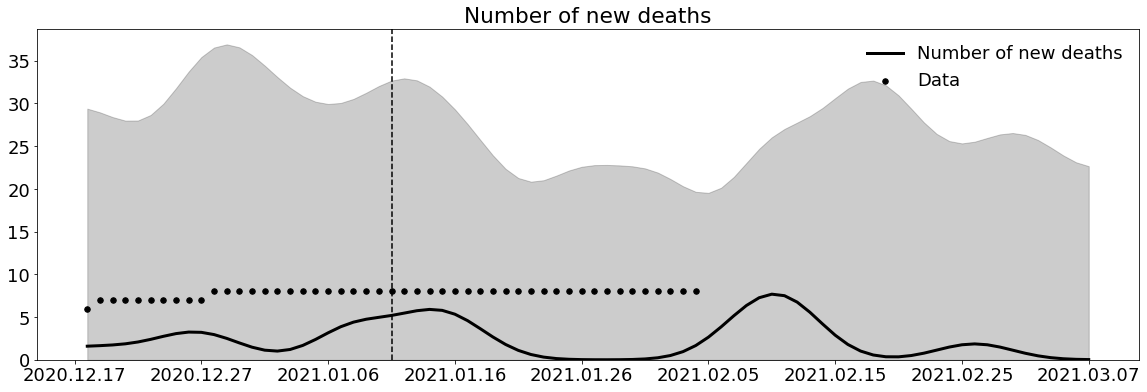

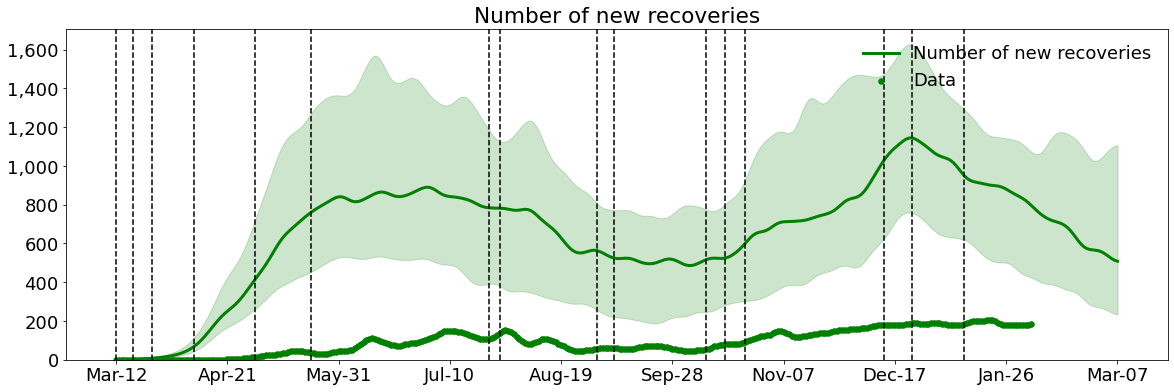

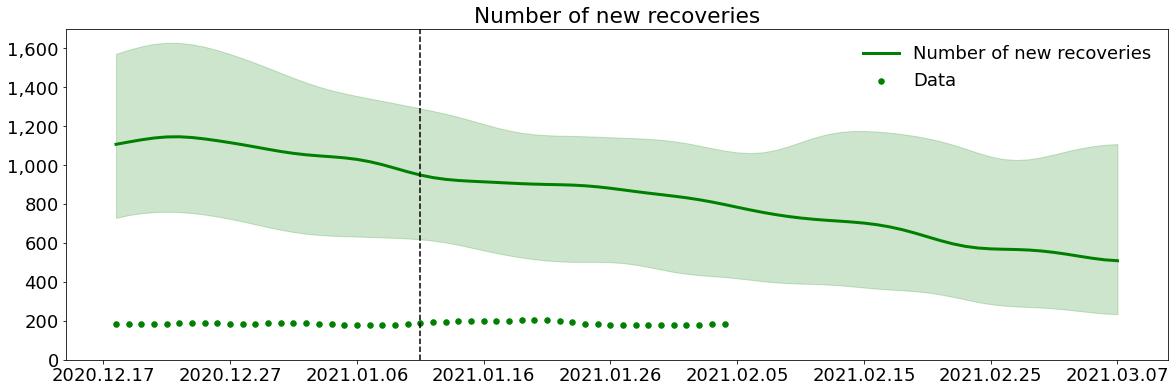

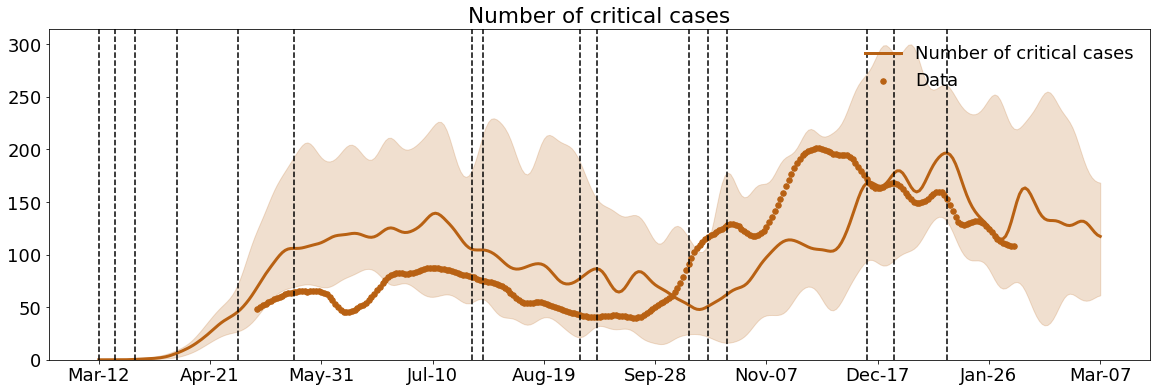

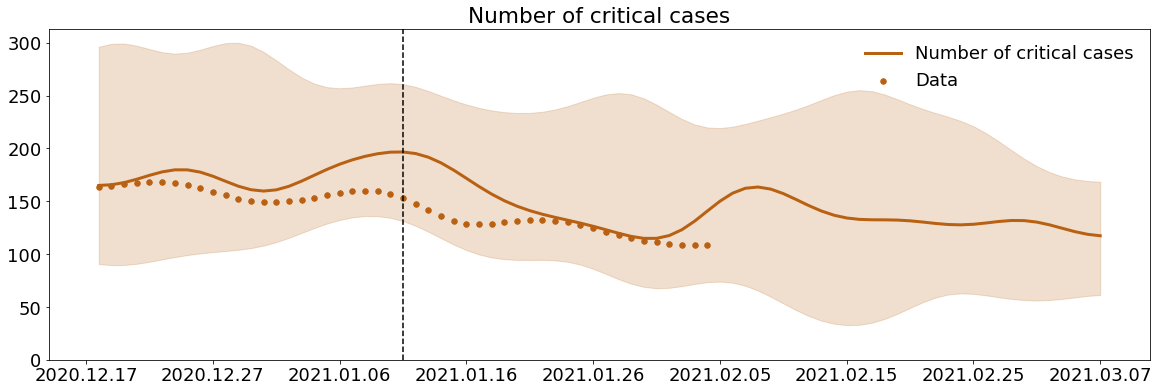

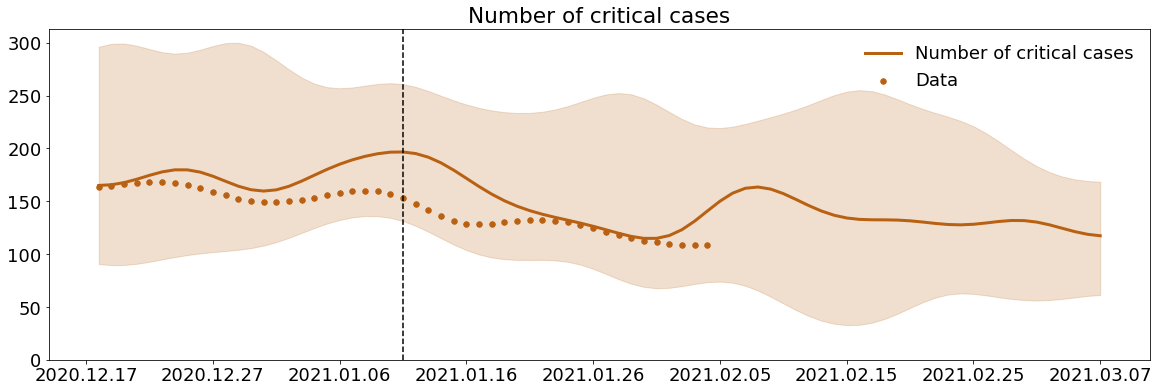

In [7]:
# plot prognose
msi=cv.load('msim_p_autocal_prognose_04_02.sim')

dday=80
test_data=None

msi.plot(to_plot=['new_diagnoses'],fig_args={'figsize': figsize})
msi.plot(to_plot=['new_diagnoses'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['new_deaths'],fig_args={'figsize': figsize},test_data=test_data)
msi.plot(to_plot=['new_deaths'],fig_args={'figsize': figsize},dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['new_recoveries'],fig_args={'figsize': figsize}, test_data=test_data)
msi.plot(to_plot=['new_recoveries'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['n_critical'],fig_args={'figsize': figsize}, test_data=test_data)
msi.plot(to_plot=['n_critical'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)
# msi.plot(to_plot=['new_severe'],fig_args={'figsize': figsize})
# msi.plot(to_plot=['new_severe'],fig_args={'figsize': figsize},dday=80, dateformat=dateformat)

# Scenarios

In [8]:
# define parameters for scenarios
n_future=40
namescen='scens_p_autocal_prognose.scens'


forecast=future_extr(filename=data_csv, df1=df1, end_day=last_day, n_future=n_future)
forecast=pd.Series(smooth(forecast),index=[df1.index[-1] + timedelta(days=i) for i in range(1, n_future+2)])
forecast.name ='new_tests'
forecast = forecast.to_frame()
forecast_data=pd.concat([df1,forecast])
forecast_data['date']=forecast_data.index
#print(forecast_data[-n_future-5:])
end_day=cv.date(forecast_data.index[-1].to_pydatetime().date())

#run scenarios
scenarios(forecast_data=forecast_data, p=p,location=location, pop_location=pop_location, b_days=b_days,
           b_changes=b_changes, school_days=school_days,start_day=start_day, school_changes=school_changes, 
           namescen=namescen)

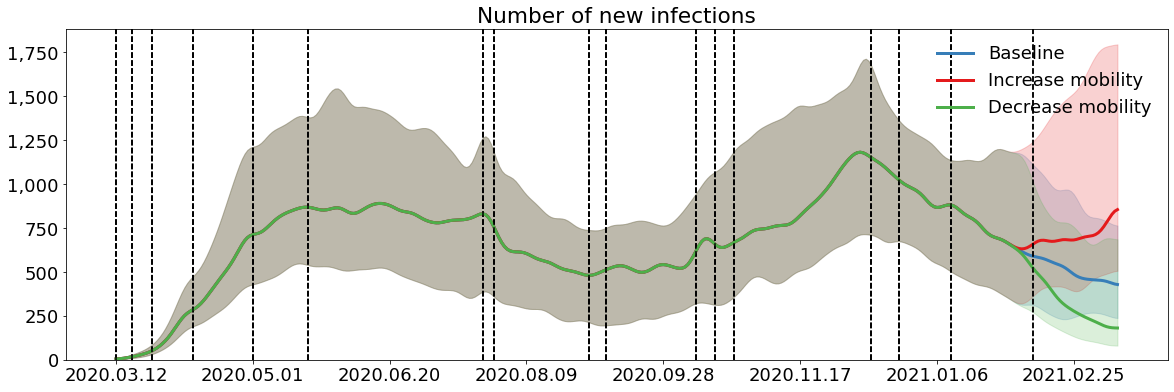

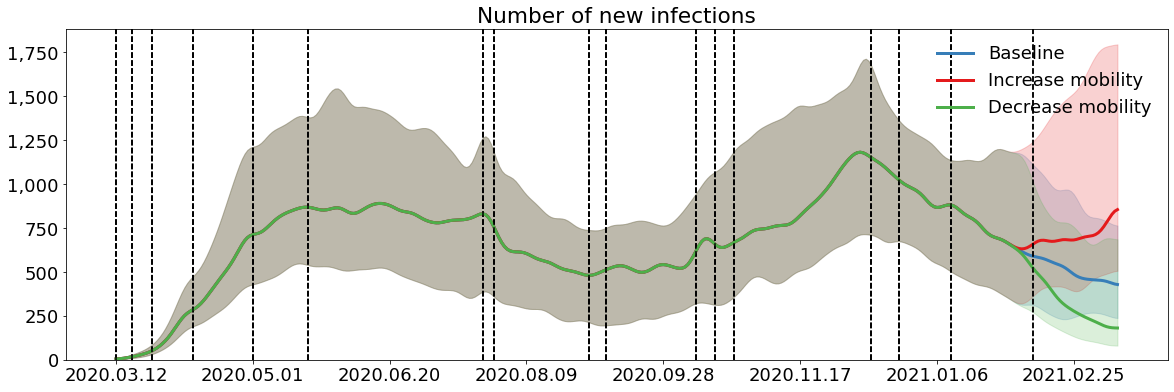

In [7]:
# plot scenarios
sce=cv.load('scens_p_autocal_prognose.scens')
sce.plot(to_plot=['new_infections'], dateformat=dateformat, fig_args={'figsize': figsize} )

# Plotting

## Interventions

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


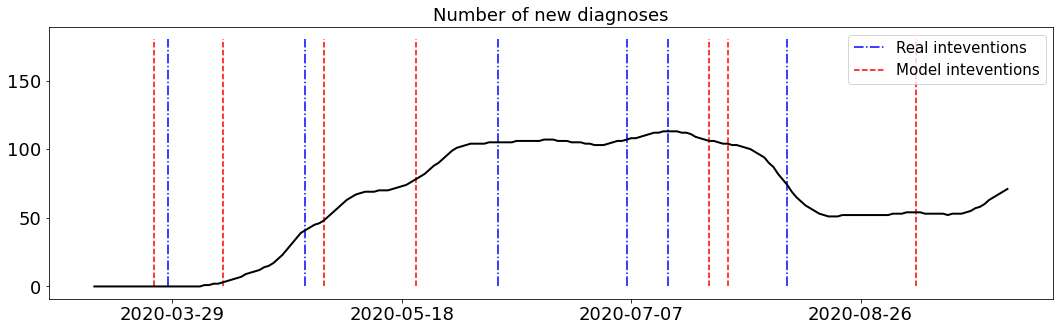

In [76]:
dday=200

# Real Novosibirsk interventions
dates = [#datetime(2020,3,18), # Зактрытие школ и университетов
        datetime(2020,3,28), # Режим самоизоляции 
        datetime(2020,4,27), # Маски
        datetime(2020,6,8), # Открытие непродовольственных магазинов
        datetime(2020,7,6), # Летние кафе и веранды
        datetime(2020,7,15), # Открытие тц
        datetime(2020,8,10),] # Открытие бассейнов и ресторанов
        #datetime(2020,9,1),  # Открытие школ и университетов
        #datetime(2020,10,24)] # Закрытие школ и университетов 
        
plot_interventions1(df=df1, b_days=b_days, dates=dates, dday=dday, save=False)

# eps saved

## r_eff

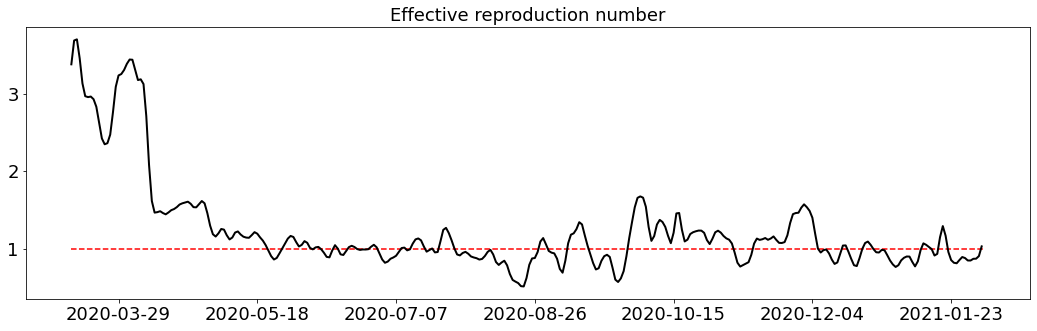

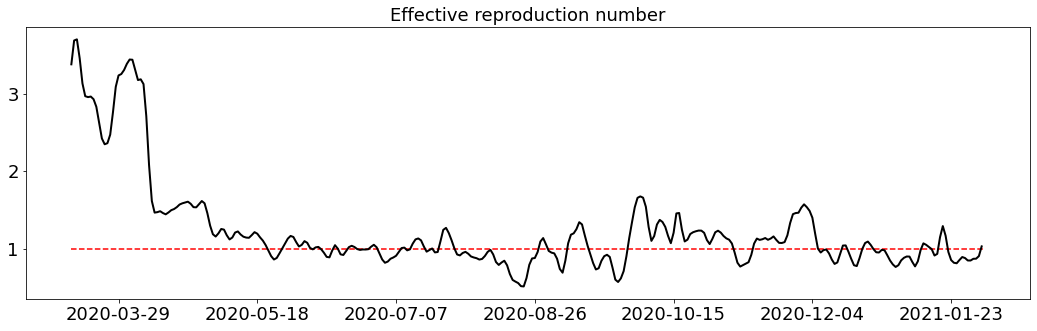

<Figure size 432x288 with 0 Axes>

In [8]:
sim=run_model(p=p, location=location, pop_location=pop_location, start_day=start_day, end_day=last_day, 
              b_days=b_days, b_changes=b_changes, data=df1, run=True, school_days=school_days,
              school_changes=school_changes)
dday=-1
plot_reff(sim=sim,dday=dday)

# eps saved

## Calibration trends

In [ ]:
def define_pars(which='best', kind='default', use_safegraph=True):
    ''' Define the parameter best guesses and bounds '''    
    pardata = {}
    pardata.update(dict(
                beta_day    = [280, 270, 300],
                beta_change = [0.6, 0.2, 1.2]
    ))
    output = {}
    for key,arr in pardata.items():
            if which == 'best':
                output[key] = arr[0]
            elif which == 'bounds':
                output[key] = arr[1:3]

    return output

In [ ]:
# Define parameters
name    = 'covasim'
storage = f'sqlite:///calibration.db'
best_thresh=1.5
#%% Load and analyze the data

sc.heading('Loading data...')
best = define_pars('best')
bounds = define_pars('bounds')
study = op.load_study(storage=storage, study_name=name)

sc.heading('Making results structure...')

results = []
n_trials = len(study.trials)
failed_trials = []
for trial in study.trials:
    data = {'index':trial.number, 'mismatch': trial.value}
    for key,val in trial.params.items():
        data[key] = val
    if data['mismatch'] is None:
        failed_trials.append(data['index'])
    else:
        results.append(data)
print(f'Processed {len(study.trials)} trials; {len(failed_trials)} failed')

sc.heading('Making data structure...')
keys = ['index', 'mismatch'] + list(best.keys())
data = sc.objdict().make(keys=keys, vals=[])
for i,r in enumerate(results):
    for key in keys:
        if key not in r:
            print(f'Warning! Key {key} is missing from trial {i}, replacing with default')
            r[key] = best[key]
        data[key].append(r[key])
df = pd.DataFrame.from_dict(data)


#%% Plotting

mismatch = sc.dcp(df['mismatch'].values)
best_mismatch = np.zeros(len(mismatch))
for i in range(len(mismatch)):
    best_mismatch[i] = mismatch[:i+1].min()
smoothed_mismatch = sc.smooth(mismatch)
pl.figure(figsize=figsize)

ax1 = pl.subplot()
#pl.plot(mismatch, alpha=0.7, label='Original')
#pl.plot(smoothed_mismatch, lw=3, label='Smoothed')
pl.plot(best_mismatch, lw=3, label='Best')
plt.legend(fontsize=15)
pl.xlabel('Trial number',fontsize=fontsize_tick)
pl.ylabel('Mismatch',fontsize=fontsize_tick)
plt.yticks(fontsize=fontsize_tick)
plt.xticks(fontsize=fontsize_tick)

ax1.set_yscale('log')

pl.savefig("calib_trend.png")


In [6]:
# C  компа ОИ

# p=[{'beta': 0.021144268043269944, 
#     'pop_infected': 17.16964887883607,
#     'symp_test': 56.15443667432404,
#     'beta_change_1': 0.8715472884934968, 
#     'beta_day_1': 29.553706974565785}, 
#    {'beta_change_2': 0.4497818505830229, 'beta_day_2': 32.030797298420765}, 
#    {'beta_change_3': 0.39828788976560475, 'beta_day_3': 51.63733555073354}, 
#    {'beta_change_4': 0.33625924955817305, 'beta_day_4': 82.05327516159832}, 
#    {'beta_change_5': 0.3604703547500003, 'beta_day_5': 106.77644946557072}, 
#    {'beta_change_6': 0.3181790060809671, 'beta_day_6': 135.3087943629867}, 
#    {'beta_change_7': 0.38634652946208003, 'beta_day_7': 176.85571582314745}, 
#    {'beta_change_8': 0.43482683582920245, 'beta_day_8': 178.4066660967688}, 
#    {'beta_change_9': 0.5104015236943604, 'beta_day_9': 241.01013400493468}, 
#    {'beta_change_10': 0.39365192417284955, 'beta_day_10': 259.9681460649014}]

In [3]:
# # basic parameters for New York State
# location='New York State'
# pop_location=20146131
# cal_keys=['new_diagnoses','new_deaths']
# cal_values=[1,1]
# pop_inf=[2000,500,30000]
# school_days=None
# school_changes=None

# # upload statistic from https://covidtracking.com/
# взять с компа ОИ

